# 5. Parallelism


In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from langgraph.constants import Send
from typing import TypedDict, Literal
from typing_extensions import Annotated
import operator

In [2]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [3]:
class OurCustomState(TypedDict):
    cities: list[str]
    facts: Annotated[list, operator.add]

class CityState(TypedDict):
    city: str

In [4]:
def city_advice(state:CityState) -> str:
    print("Node: CityAdvice")
    response = llm.invoke(input=[HumanMessage(content=f"Tell me 3 interesting facts about {state['city']}. " \
                                              "Only return the facts, no other text. Use a numbered list." \
                                              "Start with the city name. Ex. # CityName")])

    return {
        "facts": [response.content]
    }

In [11]:
def random_city_generator(state: OurCustomState) -> Command[Literal["city_advice", "final_node"]]:
    print("Node: Random City Generator")
    response = llm.invoke(input="Return 3 random city names in India, comma separated.")
    cities = response.content.split(",")
    if len(cities) > 0:
        return Command(
            update={
                "cities": cities
            },
            goto=[
                Send(
                    node = "city_advice",
                    arg = {
                        "city": city.strip()
                    }
                )
            for city in cities]
        )
    else:
        return Command(
            update={
                "cities": []
            },
            goto=["final_node"]
        )

In [12]:
def final_node(state: OurCustomState):
    print("Node: Final")
    print("Cities:", state["cities"])
    print("Facts:", state["facts"])
    return {}

In [13]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(OurCustomState)

builder.add_node("random_city_generator", random_city_generator)
builder.add_node("city_advice", city_advice)
builder.add_node("final_node", final_node)

builder.add_edge(START, "random_city_generator")
builder.add_edge("city_advice", "final_node")
builder.add_edge("final_node", END)
graph = builder.compile()

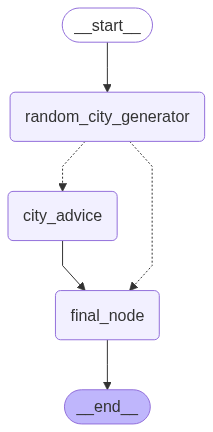

In [14]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [15]:
state = graph.invoke(input = {})

Node: Random City Generator
Node: CityAdviceNode: CityAdvice
Node: CityAdvice

Node: Final
Cities: ['Mumbai', ' Jaipur', ' Chennai']
Facts: ['# Mumbai  \n1. Mumbai is home to the largest Film Industry in the world, Bollywood, producing over 1,000 films annually.  \n2. The city’s iconic Gateway of India was built in 1924 to commemorate the visit of King George V and Queen Mary to India.  \n3. Mumbai is one of the few cities in the world that has a population density of over 20,000 people per square kilometer.', '# Jaipur  \n1. Jaipur is known as the "Pink City" because the buildings in its old city were painted rose pink in 1876 to welcome the Prince of Wales, symbolizing hospitality.  \n2. The Jantar Mantar in Jaipur, built in the 18th century, is the largest stone sundial in the world and is a UNESCO World Heritage site.  \n3. Jaipur was one of the first planned cities in India, designed by architect Vidyadhar Bhattacharya in 1727 based on ancient Indian architectural principles of Va

In [16]:
for fact in state["facts"]:
    print(fact)

# Mumbai  
1. Mumbai is home to the largest Film Industry in the world, Bollywood, producing over 1,000 films annually.  
2. The city’s iconic Gateway of India was built in 1924 to commemorate the visit of King George V and Queen Mary to India.  
3. Mumbai is one of the few cities in the world that has a population density of over 20,000 people per square kilometer.
# Jaipur  
1. Jaipur is known as the "Pink City" because the buildings in its old city were painted rose pink in 1876 to welcome the Prince of Wales, symbolizing hospitality.  
2. The Jantar Mantar in Jaipur, built in the 18th century, is the largest stone sundial in the world and is a UNESCO World Heritage site.  
3. Jaipur was one of the first planned cities in India, designed by architect Vidyadhar Bhattacharya in 1727 based on ancient Indian architectural principles of Vastu Shastra.
# Chennai  
1. Chennai is home to the Marina Beach, which is the second longest urban beach in the world, stretching about 13 kilometers. 